In [20]:
import timeit
import pandas as pd
from IPython.display import display
from carla.data.catalog import OnlineCatalog, CsvCatalog

from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances

from carla.recourse_methods.catalog import CCHVAE

from carla.evaluation.catalog import load_oracle
import carla.evaluation.catalog as evaluation_catalog

import umap 
import warnings
import seaborn as sns
from msid import msid_score
import matplotlib.pyplot as plt 

warnings.filterwarnings("ignore")

# Setup experiment

In [4]:
data_name = "adult"
dataset = OnlineCatalog(data_name)

In [5]:
# load catalog model
model_type = "ann"
ml_model = MLModelCatalog(
    dataset,
    model_type=model_type,
    load_online=True,
    backend="pytorch"
)

if isinstance(dataset, OnlineCatalog):
    target = dataset.catalog['target']
elif isinstance(dataset, CsvCatalog):
    target = dataset.target

In [6]:
hyperparams = {
    "data_name": dataset.name,
    "n_search_samples": 100,
    "p_norm": 1,
    "step": 0.1,
    "max_iter": 1000,
    "clamp": True,
    "binary_cat_features": False,
    "vae_params": {
        "layers": [sum(ml_model.get_mutable_mask()), 512, 256, 8],
        "train": False,
        "weights_path": r'D:\PycharmProjects\XAIRobustness\CARLA\carla\recourse_methods\autoencoder\weights',
        "save_to": '',
        "lambda_reg": 1e-6,
        "epochs": 5,
        "lr": 1e-3,
        "batch_size": 32,
    },
}

# define your recourse method
recourse_method = CCHVAE(ml_model, hyperparams)

In [7]:
# get some negative (class = 0) instances
factuals, factuals_pos = predict_negative_instances(ml_model, dataset.df_test, return_pos=True)
factuals = factuals[:1000]

# Visualize class distributions via dimensionality reduction

In [73]:
reducer = umap.UMAP(n_neighbors=60,
                    min_dist=0.5,
                    metric='correlation')

In [74]:
print('Percentage of missing values\n', dataset.df_test.isnull().sum())
print('\n', dataset.df_test.describe())

Percentage of missing values
 age                           0
fnlwgt                        0
education-num                 0
capital-gain                  0
capital-loss                  0
hours-per-week                0
income                        0
marital-status_Non-Married    0
native-country_US             0
occupation_Other              0
race_White                    0
relationship_Non-Husband      0
sex_Male                      0
workclass_Private             0
dtype: int64

                 age        fnlwgt  education-num  capital-gain  capital-loss  \
count  12208.000000  12208.000000   12208.000000  12208.000000  12208.000000   
mean       0.296271      0.120315       0.604806      0.011118      0.019062   
std        0.188116      0.071831       0.169746      0.075160      0.089686   
min        0.000000      0.000000       0.000000      0.000000      0.000000   
25%        0.150685      0.070986       0.533333      0.000000      0.000000   
50%        0.273973      0.

In [75]:
from sklearn.preprocessing import StandardScaler

X_test_std = StandardScaler().fit_transform(dataset.df_test)

reduced_test_df = reducer.fit_transform(X_test_std)

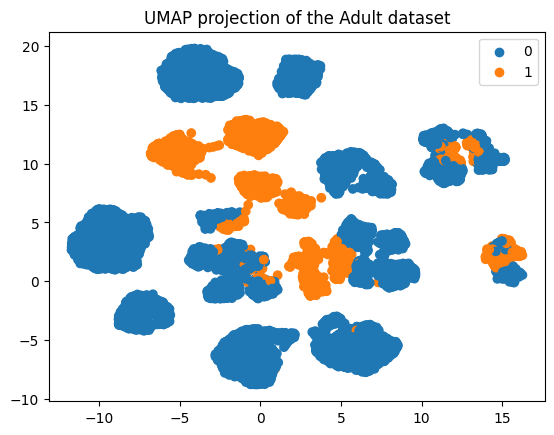

In [76]:

fig, ax = plt.subplots()


scatter = ax.scatter(reduced_test_df[:, 0], reduced_test_df[:, 1],
                     c=[sns.color_palette()[x] for x in dataset.df_test['income']])


legend_aliases = [
    plt.scatter([], [], marker='o', label='0', c='tab:blue'),
    plt.scatter([], [], marker='o', label='1', c='tab:orange'),
]

plt.legend(handles=legend_aliases, loc='upper right')

#plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Adult dataset');

In [59]:
from sklearn import manifold

In [66]:
tsne = manifold.TSNE(n_components=2, verbose=1, init='random', learning_rate='auto', random_state=123)
test_df_tsne = tsne.fit_transform(X_test_std)

# Just turn into dataframe
df_tsne = pd.DataFrame(test_df_tsne)
df_tsne.rename(columns = {0:'comp-1', 1:'comp-2'}, inplace = True)
df_tsne['label'] = dataset.df_test['income']

df_tsne.head()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12208 samples in 0.020s...
[t-SNE] Computed neighbors for 12208 samples in 1.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12208
[t-SNE] Computed conditional probabilities for sample 2000 / 12208
[t-SNE] Computed conditional probabilities for sample 3000 / 12208
[t-SNE] Computed conditional probabilities for sample 4000 / 12208
[t-SNE] Computed conditional probabilities for sample 5000 / 12208
[t-SNE] Computed conditional probabilities for sample 6000 / 12208
[t-SNE] Computed conditional probabilities for sample 7000 / 12208
[t-SNE] Computed conditional probabilities for sample 8000 / 12208
[t-SNE] Computed conditional probabilities for sample 9000 / 12208
[t-SNE] Computed conditional probabilities for sample 10000 / 12208
[t-SNE] Computed conditional probabilities for sample 11000 / 12208
[t-SNE] Computed conditional probabilities for sample 12000 / 12208
[t-SNE] Computed conditional probabilities for sam

,comp-1,comp-2,label
0,-3.638956,-65.261398,0
1,16.711475,-4.005919,1
2,39.639435,-16.980045,0
3,-22.285501,-53.396534,0
4,-60.677490,42.013855,0


[Text(0.5, 1.0, 'T-SNE projection for Adult dataset')]

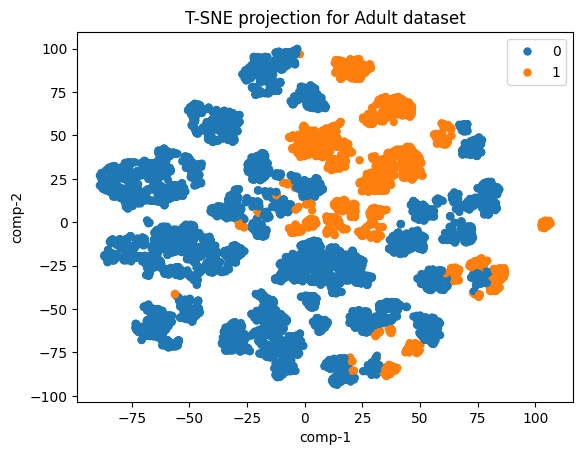

In [77]:
sns.scatterplot(
  data=df_tsne,
  hue=df_tsne['label'].tolist(),
  x="comp-1", y = "comp-2", 
  edgecolor='none'
  
).set(title="T-SNE projection for Adult dataset") 

# Generate CE

In [78]:

# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it
start = timeit.default_timer()
counterfactuals = recourse_method.get_counterfactuals(factuals)
stop = timeit.default_timer()


In [ ]:
evaluation_measures = []

# now run all implemented measurements and create a
# DataFrame which consists of all results
pipeline = [measure.get_evaluation(counterfactuals=counterfactuals, factuals=factuals)
            for measure in evaluation_measures]
results = pd.concat(pipeline, axis=1)

display(results)